In [1]:
from keras.applications.xception import Xception
from keras.models import load_model
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

# pre-process test images
img_size = 299  # match Xception input size
def resize(image):
    h, w, c = image.shape
    cropped = image
    if h < w:
        diff = (w - h) // 2
        cropped = image[:, diff: (diff + h), :]
    elif h > w:
        diff = (h - w) // 2
        cropped = image[diff: (diff + w), :, :]

    h, w, c = cropped.shape
    if h > img_size:    # shrink
        return cv.resize(cropped, (img_size, img_size), interpolation=cv.INTER_AREA)
    elif h < img_size:  # enlarge
        return cv.resize(cropped, (img_size, img_size), interpolation=cv.INTER_CUBIC)
    else:
        return cropped
    
test_dir = './raw/test'
# test_dir=os.listdir('./images1/test')
# filenames=[f.split('.')[0] for f in test_dir ]
filenames = glob(os.path.join(test_dir, '*.jpg'))

for i, file in enumerate(filenames):
    print('processing:', file)
    img = cv.imread(file)
    resized = resize(img)
    img_name = str(i) + '.png'
    filepath = os.path.join(test_dir, img_name)
    cv.imwrite(filepath, resized)


def load_test_images(file_list):
    test_set = list()
    test_set_rgb = list()
    for file in file_list:
        print(file)
        img = cv.imread(file)
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        test_set.append(img)
        test_set_rgb.append(img_rgb)

    return np.asarray(test_set), np.asarray(test_set_rgb)


# load test images
test_dir = './raw/test'
filenames = glob(os.path.join(test_dir, '*.png'))
images, images_rgb = load_test_images(filenames)

# calculate from the training set
channel_mean = np.array([110.73151039, 122.90935242, 136.82249855])
channel_std = np.array([69.39734207, 67.48444001, 66.66808662])

# normalize images
images = images.astype('float32')
for j in range(3):
    images[:, :, :, j] = (images[:, :, :, j] - channel_mean[j]) / channel_std[j]

# make predictions
base_model = Xception(include_top=False, weights='imagenet', pooling='avg')
iot_model = load_model('./model/iot_model_1553242985.h5')
features = base_model.predict(images,batch_size=20)
predictions = iot_model.predict(features,batch_size=20)




I:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


processing: ./raw/test\img.jpg
./raw/test\0.png
Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 19s 0us/step
Instructions for updating:
Use tf.cast instead.


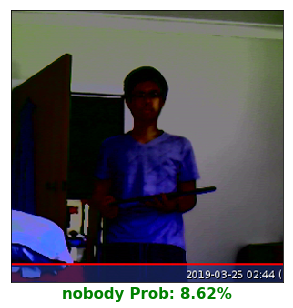

In [3]:
# plot results
fig = plt.figure()
fig.suptitle('Predictions on Test Images', size=15, weight='bold')
fig.subplots_adjust(hspace=1, wspace=5)
for i in range(1):
#     ax = fig.add_subplot(4, 3, i+1)
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.imshow(images_rgb[i], aspect='auto')
    ax.imshow(images_rgb[i])
    result = 'nobody Prob: {:.2f}%'.format(predictions[i][0]*100)
    ax.set_xlabel(result, color='g', size=15, weight='bold', horizontalalignment='center')

plt.show()